In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

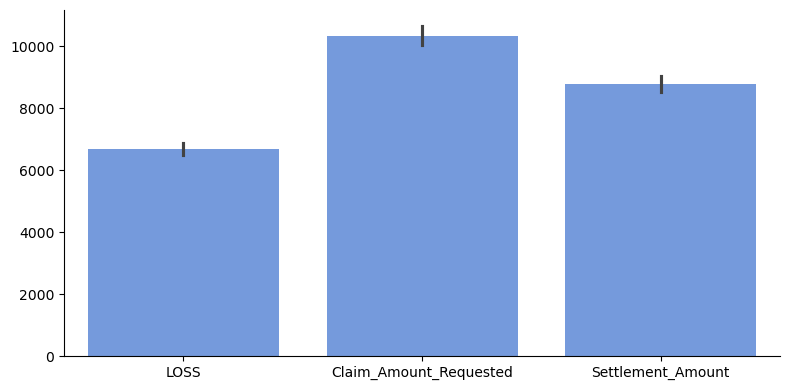

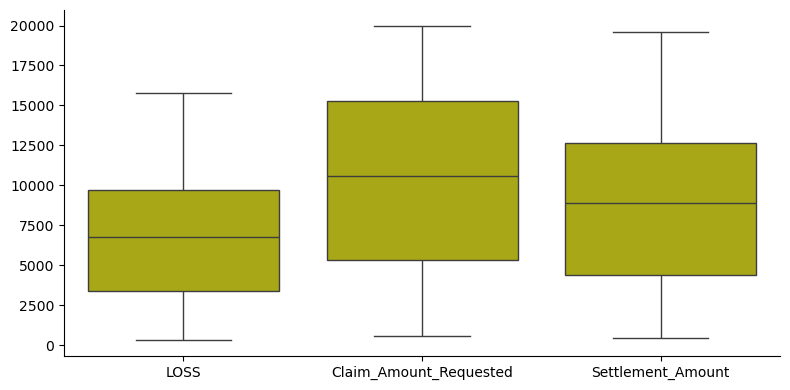

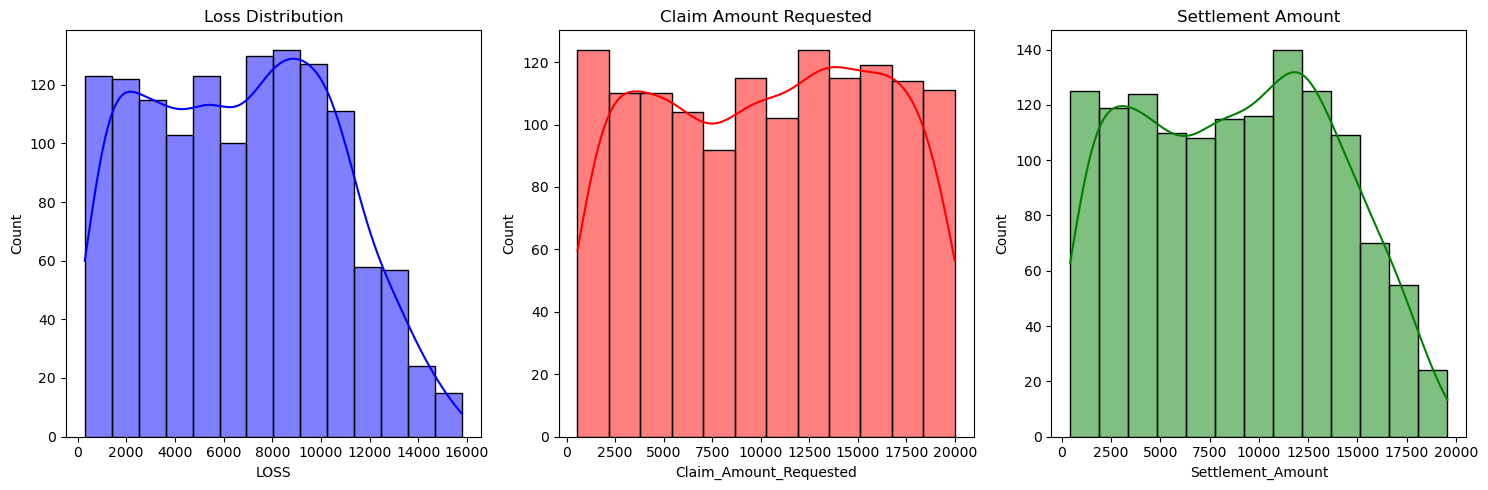

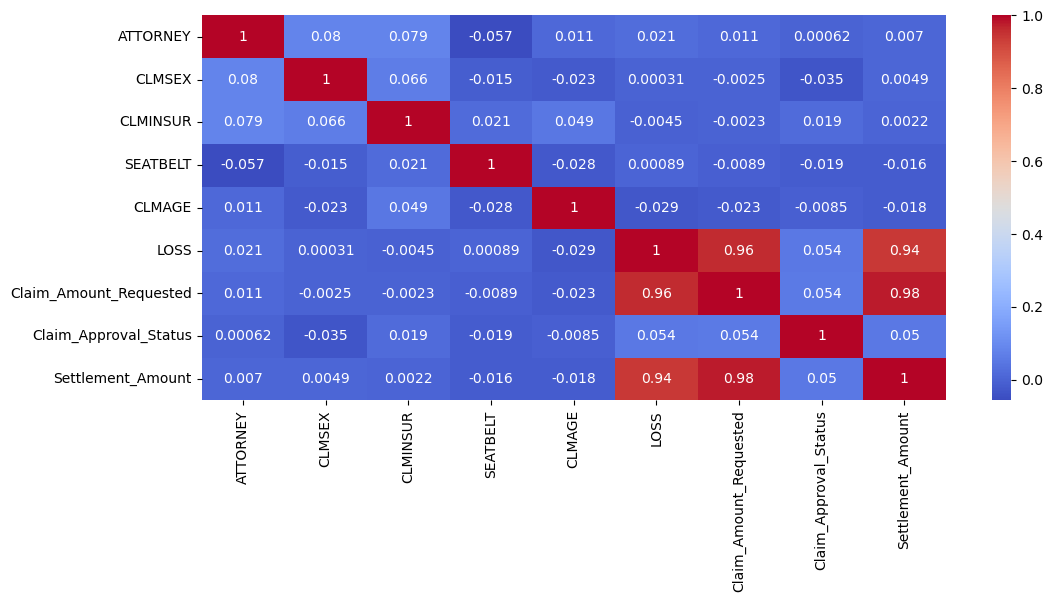

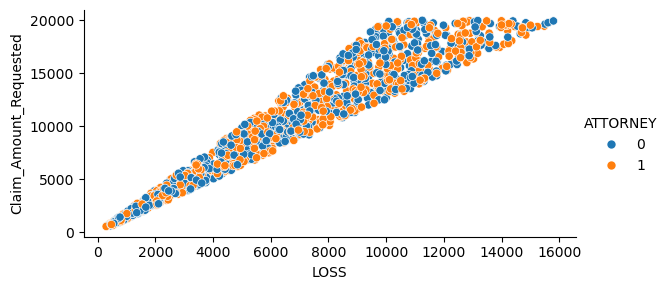

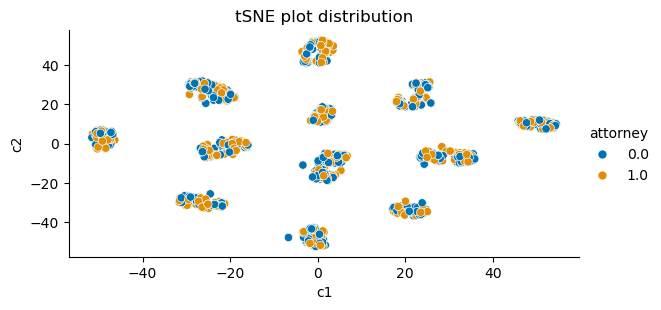

In [9]:
df=pd.read_csv('Updated_Claimants_Dataset.csv')
df.info
df.describe()
df.head()

df[df.duplicated()]
df.isnull().sum()
df.drop('CASENUM',axis=1,inplace=True)

sns.catplot(df[['LOSS','Claim_Amount_Requested','Settlement_Amount']],kind='bar',aspect=2,height=4,color='cornflowerblue')
sns.catplot(df[['LOSS','Claim_Amount_Requested','Settlement_Amount']],kind='box',aspect=2,height=4,color='y')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(df['LOSS'],kde=True,ax=axes[0],color='b',)
axes[0].set_title('Loss Distribution')
sns.histplot(df['Claim_Amount_Requested'],kde=True,ax=axes[1],color='r')
axes[1].set_title('Claim Amount Requested')
sns.histplot(df['Settlement_Amount'],kde=True,ax=axes[2],color='g')
axes[2].set_title('Settlement Amount')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
sns.relplot(df,x=df['LOSS'],y = df['Claim_Amount_Requested'],height=3,aspect=2,hue='ATTORNEY')
plt.show()

from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median')
df[['CLMSEX','CLMINSUR','SEATBELT','CLMAGE']]=imputer.fit_transform(df[['CLMSEX','CLMINSUR','SEATBELT','CLMAGE']])

from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
for col in ['Accident_Severity', 'Policy_Type', 'Driving_Record']:
    df[col] = encoder.fit_transform(df[col])
    
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
for x in ['CLMAGE','LOSS','Claim_Amount_Requested','Settlement_Amount']:
    df[x]=scaler.fit_transform(df[[x]])

df.drop(['Claim_Amount_Requested','Claim_Approval_Status','Driving_Record'],inplace=True,axis=1)

from sklearn.ensemble import IsolationForest
iso=IsolationForest(n_estimators=100,max_samples=20,contamination=0.1)
a=iso.fit_predict(df)
df['anomaly']=a
df['anomaly'].value_counts()
df=df[df['anomaly']==1].drop(columns='anomaly')

X=df.iloc[:,1:]
y=df.iloc[:,0]
from sklearn.model_selection import train_test_split,GridSearchCV

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
sarr=scaler.fit_transform(df)
sdata=pd.DataFrame(sarr,columns=df.columns)
sdata
t=sdata.drop('ATTORNEY',axis=1)
pca=PCA(n_components=8)
pca.fit_transform(t)
np.cumsum(pca.explained_variance_ratio_)

from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,random_state=42)
arr=tsne.fit_transform(X)
ddf=pd.DataFrame(arr,columns=['c1','c2'])
ddf['attorney']=df['ATTORNEY']

sns.relplot(ddf,x='c1',y='c2',kind='scatter',hue='attorney',palette='colorblind',height=3,aspect=2)
plt.title('tSNE plot distribution')
plt.show()

from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()
parameter={
    'n_estimators':[50,100,150],
    'criterion':["gini", "entropy"],
    'max_depth':[10,20,30],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[3,4,5],
    'max_features':["sqrt", "log2"]
}

In [3]:
gridsearch=GridSearchCV(estimator=model,param_grid=parameter,scoring='accuracy',cv=3,n_jobs=-1)
gridsearch.fit(X_train,y_train)
print(gridsearch.best_params_)
clf=gridsearch.best_estimator_

{'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 150}


              precision    recall  f1-score   support

           0       0.73      0.73      0.73       121
           1       0.73      0.73      0.73       121

    accuracy                           0.73       242
   macro avg       0.73      0.73      0.73       242
weighted avg       0.73      0.73      0.73       242



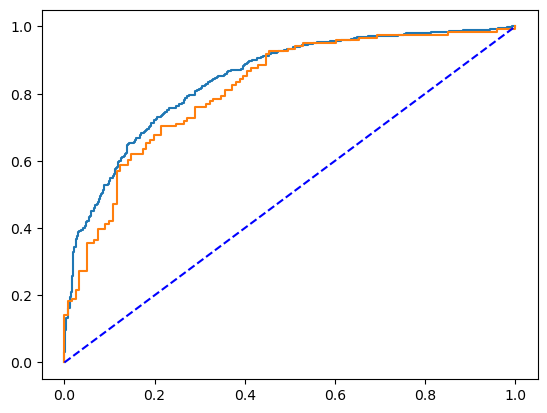

In [10]:
yhat=clf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,yhat))

from sklearn.metrics import roc_curve
y_prob = clf.predict_proba(X_train)[:,1]
fpr,tpr,threshold=roc_curve(y_train,y_prob)
y_test_prob = clf.predict_proba(X_test)[:,1]
fpr_t,tpr_t,threshold_t=roc_curve(y_test,y_test_prob)
plt.plot(fpr,tpr)
plt.plot(fpr_t,tpr_t)
plt.plot([0,1],[0,1],linestyle='--',color='blue')
plt.show()

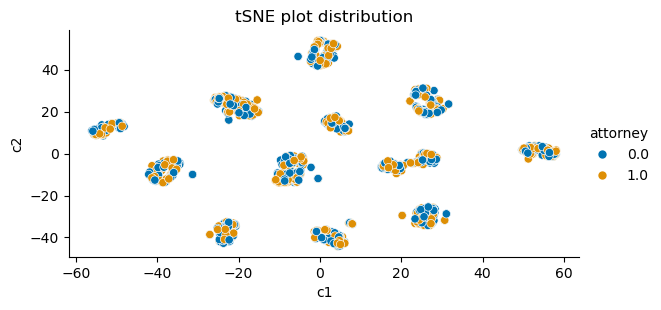

In [62]:
from sklearn.manifold import TSNE
tsne=TSNE(n_components=2,random_state=42)
arr=tsne.fit_transform(X)
ddf=pd.DataFrame(arr,columns=['c1','c2'])
ddf['attorney']=df['ATTORNEY']

sns.relplot(ddf,x='c1',y='c2',kind='scatter',hue='attorney',palette='colorblind',height=3,aspect=2)
plt.title('tSNE plot distribution')
plt.show()

In [64]:
from pickle import dump
dump(clf,open('Insure.pkl','wb'))